<a href="https://colab.research.google.com/github/leeCodingStudio/KDT_homework/blob/master/3_%ED%8C%80_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 과제
* 전이 학습으로 강아지와 고양이 구분하기
* https://www.kaggle.com/tongpython/cat-and-dog

In [ ]:
import os

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'lehj2308'                      # username
os.environ['KAGGLE_KEY'] = '417fc1713952564bdf914a973d22d757'   # key

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip -q cat-and-dog.zip

100% 218M/218M [00:10<00:00, 24.7MB/s]
100% 218M/218M [00:10<00:00, 20.9MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [ ]:
def target_transforms(target):
    return torch.FloatTensor([target])

In [ ]:
image_datasets = {
    'train': datasets.ImageFolder('training_set/training_set', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('test_set/test_set', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation':DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

8005 2023


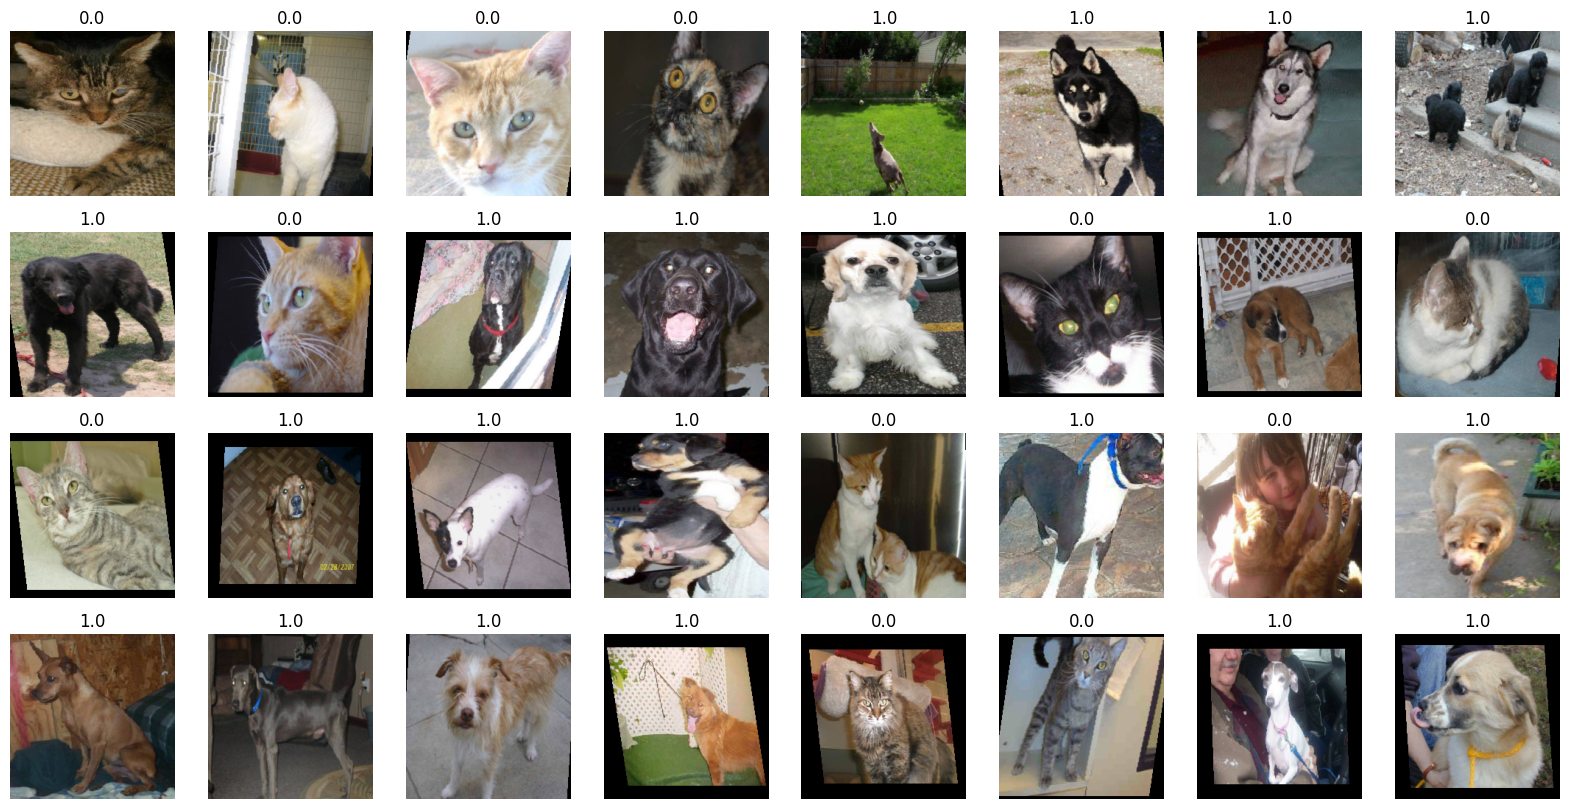

In [ ]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')

In [ ]:
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

epochs = 1

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss.item()

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/1, Loss: 0.0695, Accuracy: 97.27%
validation: Epoch    1/1, Loss: 0.0336, Accuracy: 99.17%


In [ ]:
from PIL import Image

img1 = Image.open('/content/test_set/test_set/cats/cat.4025.jpg')
img2 = Image.open('/content/test_set/test_set/dogs/dog.4001.jpg')

In [ ]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

In [ ]:
test_batch = torch.stack([img1_input, img2_input]) # 두 개를 붙임
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [ ]:
y_pred = model(test_batch)
y_pred

tensor([[6.0377e-07],
        [9.4507e-01]], device='cuda:0', grad_fn=<SigmoidBackward0>)

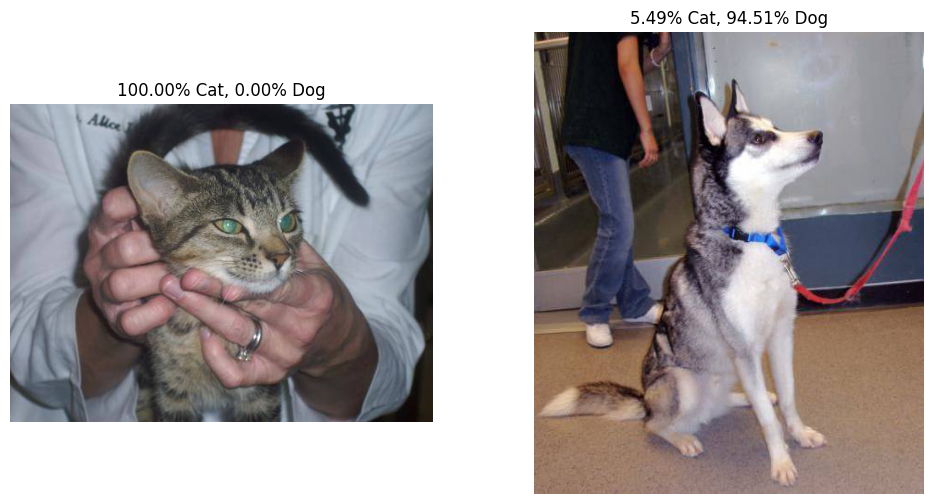

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title(f'{(1-y_pred[0, 0]) * 100:.2f}% Cat, {y_pred[0, 0] * 100:.2f}% Dog')
axes[0].imshow(img)
axes[0].axis('off')

axes[1].set_title(f'{(1-y_pred[1, 0]) * 100:.2f}% Cat, {y_pred[1, 0] * 100:.2f}% Dog')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()